# Imports

In [145]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk import download
download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ahmed Mustafa
[nltk_data]     Malik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Defining Tweet Class

In [146]:
class Tweet:
    def __init__(self):
        self.uid = None
        self.content = ''
        self.sentiment = ''

# Definining Methods for Data Loading and Cleaning

In [147]:
def cleanTweet(tweet):
#     print(tweet.content,"\n")
    tweet.content = re.sub(r'\_', '', tweet.content) # remove underscores
    tweet.content = re.sub(r'…', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'\.', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'^RT[\s]+', '', tweet.content) # remove RT
    tweet.content = re.sub("[#@©àâ€¦¥°¤ð¹ÿœ¾¨‡†§‹²¿¸ˆ]", '', tweet.content) # remove weird symbols
    tweet.content = tweet.content.split("http")[0].split('https')[0] # remove http/https
    tweet.content = ''.join([i for i in tweet.content if not i.isdigit()]) # remove digits
    tweet.content = ''.join([word for word in tweet.content if word not in string.punctuation]) # remove punctuations
    tweet.content = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True).tokenize(tweet.content)
    tweet.content = ' '.join([i for i in tweet.content]) # convert to string
#     print(tweet.content)
#     print("============================================================================")
    return tweet

def load_stop_words():
    stopwords_english = stopwords.words('english')
    stopwords_hinglish = []
    with open('data/hinglish_stopwords.txt','r') as fp:
        while True:
            line = fp.readline()
            if not line:
                break
            stopwords_hinglish.append(line.strip())
    return stopwords_english, stopwords_hinglish

def readFile(filename, test_data=False):
    stemmer_english = PorterStemmer()
    stopwords_english, stopwords_hinglish = load_stop_words()
    all_tweets = []
    with open(filename, 'r', encoding="utf8") as fp:
        tweet = Tweet()
        last_one = False
        while True:
            line = fp.readline()
            if not line:
                last_one = True
            if len(line.split()) > 1 or last_one==True:
                if last_one==True or line.split()[0] == 'meta':
                    if len(tweet.content) > 0 or last_one==True:
                        all_tweets.append(cleanTweet(tweet))
                        if last_one==True:
                            break
                        tweet = Tweet()
                    tweet.uid = line.split()[1]
                    tweet.sentiment = line.split()[2] if test_data==False else None
                else:
                    if line.split()[1] == "Eng":
                        if line.split()[0] not in stopwords_english:
                            tweet.content += stemmer_english.stem(line.split()[0]) + " "
                    elif line.split()[1] == "Hin":
                        if line.split()[0] not in stopwords_hinglish:
                            tweet.content += line.split()[0] + " "
                    else:
                        tweet.content += line.split()[0] + " "
        return all_tweets

# Defining Methods for creating Embeddings

## Frequency Based Method

In [148]:
def frequency_based_embeddings(all_tweets):
    freqs = dict()
    for i in all_tweets:
        for word in i.content.split():
            pair = (word, i.sentiment)
            freqs[pair] = freqs.get(pair, 0) + 1
    all_positive_tweets = [i.content for i in all_tweets if i.sentiment=='positive']
    all_negative_tweets = [i.content for i in all_tweets if i.sentiment=='negative']
    all_neutral_tweets = [i.content for i in all_tweets if i.sentiment=='neutral']
    tweets = all_neutral_tweets + all_positive_tweets + all_negative_tweets
    X = np.empty((0,4))
    for i in tweets:
        neutral_words_freq = 0
        positive_words_freq = 0
        negative_words_freq = 0
        for word in i.split():
            neutral_words_freq += freqs.get((word,'neutral'),0)
            positive_words_freq += freqs.get((word,'positive'),0)
            negative_words_freq += freqs.get((word,'negative'),0)
        X = np.append(X, np.array([[1, neutral_words_freq, positive_words_freq, negative_words_freq]]), axis=0)
    Y = np.append(np.zeros(len(all_neutral_tweets)), np.ones(len(all_positive_tweets)))
    Y = np.append(Y, np.full(len(all_negative_tweets),2))
    return X,Y

# Defining Method for Showing Results

In [149]:
def plot_confusion_matrix(cm,title='Confusion Matrix',cmap=plt.cm.Greens):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    classes = ['neutral','positive','negative']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def show_results(y_test, y_pred):
    print("F1 Score: ", f1_score(y_test, y_pred, average="weighted"))
    print()
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    plot_confusion_matrix(cnf_matrix)

# ===================================================

# Mission Control - Training

### Data Loading

In [150]:
# all_tweets = readFile(r'data\train\train_14k_split_conll.txt')
# all_tweets.extend(readFile(r'data\train\dev_3k_split_conll.txt'))
all_tweets = (readFile(r'data\train\train_conll.txt'))
# all_tweets.extend(readFile(r'data\train\trial_conll.txt'))

### Creating File for Fast-Text 

In [151]:
with open('data/fast-text-data/data.train.txt', 'w', encoding="utf-8") as fp:
    for i in all_tweets:
        fp.write("__label__"+i.sentiment+" "+i.content+"\n")

### Model - Training

In [172]:
import fasttext
model = fasttext.train_supervised('data/fast-text-data/data.train.txt',epoch=5,wordNgrams=2)

# ===================================================

# Mission Control - Prediction

### Loading Prediction Data

In [173]:
actual_labels_dict = dict()
with open(r'data\test\test_labels_hinglish.txt','r') as fp:
    line = fp.readline()
    while True:
        line = fp.readline()
        if not line:
            break
        actual_labels_dict[line.strip().split(',')[0]] = line.strip().split(',')[1]
all_test_tweets = readFile(r'data\test\Hindi_test_unalbelled_conll_updated.txt',test_data=True)
for i in all_test_tweets:
    i.sentiment = actual_labels_dict[i.uid]

### Getting the Predictions

In [174]:
predictions = []
for i in all_test_tweets:
    predictions.append(model.predict(i.content))

### The Results

F1 Score:  0.6726073979061383



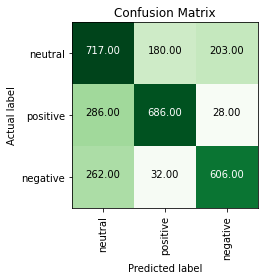

In [175]:
actual_num = []
for i in all_test_tweets:
    if i.sentiment == "neutral":
        actual_num.append(0)
    elif i.sentiment == "positive":
        actual_num.append(1)
    elif i.sentiment == "negative":
        actual_num.append(2)
predictions_num = []
for i in predictions:
    if i[0][0] == "__label__neutral":
        predictions_num.append(0)
    elif i[0][0] == "__label__positive":
        predictions_num.append(1)
    elif i[0][0] == "__label__negative":
        predictions_num.append(2)

show_results(actual_num, predictions_num)

# Analysing Incorrect Results

In [176]:
for i in range(len(actual_num)):
    if (actual_num[i]!=predictions_num[i]):
        print("Actual:",all_test_tweets[i].sentiment)
        print("Predicted:",predictions[i][0][0][9:])
        print(all_test_tweets[i].content)
        print("=====================================================================")

Actual: neutral
Predicted: positive
alloo pyaz tomat allah pak naam nazar aa pr aankhon samne allah pak nazar
Actual: neutral
Predicted: positive
sharmakef wer almost final threeday ramadan ” close finish line so let make sure doubl i
Actual: negative
Predicted: neutral
sadifabi shahidmasooddr tm dikha rhy asli auqaat wese btao tou ye propaganda kyu krta shahid masood
Actual: positive
Predicted: neutral
dheeraj nirahua msunilbishnoi wah shandaar jabab
Actual: negative
Predicted: neutral
modi lehar kisano baras kehar tut haath pao road buri halato aasar aajtak bbcbreak
Actual: positive
Predicted: neutral
ravindraj tarekfatah yarr india b life st time india posit dekha appreci u ÿµÿÿ ® ÿ
Actual: positive
Predicted: neutral
baijnathmourya mssirsa aapkamanojs arvindkejriwal haan mai free wifi dunga free water sasti bijli doo
Actual: negative
Predicted: neutral
asifnkhan saumen banerj e jhasanjay time circumst ke change bada bewakuf
Actual: neutral
Predicted: positive
sicilian mafia bhaai e

Actual: positive
Predicted: negative
newstvchannel asadowaisi bjpindia we choosen modi ji not sit purpos balki desh namak ha
Actual: positive
Predicted: neutral
ayushmannk anubhavsinha sayanigupta mdzeeshanayyub zeestudio zeemusiccompani boy trailer chhaa
Actual: positive
Predicted: neutral
bilalsohalal i need go umrah i ™ better place spiritu point life appreci musli
Actual: positive
Predicted: negative
rozo write ali kay tweet ÿ ˜ ‚ ÿ ˜ ‚ ÿ ˜ ‚ loundo kia tm loogo darmiyan
Actual: positive
Predicted: neutral
swagg datdude lala la shay y ™ special lol
Actual: negative
Predicted: positive
kash vavijaan bulati aapki nayi movie bharat dekhenge katrinakaif vavi film hit
Actual: positive
Predicted: neutral
laghateparthofc anu prerna way ran save and ram ram jay rajaraam background watta scene ÿ ‘  ÿ ’ ¯ pa
Actual: positive
Predicted: neutral
ungraduateg ytcreatorsindia bhai app channel jaroor wapas aaega
Actual: positive
Predicted: neutral
dogmomusa ohhh i wonder snap map load thought int

Actual: negative
Predicted: neutral
paksarfrazbugti jo baloch kisi famili per baat karay personal hojaye usko block balkay kuttay tara
Actual: positive
Predicted: neutral
geetinsa gurmeetramrahim thaxxx sohne satguru ji pitaji sari sadh sangt pr rehmet rakhna ji ÿ ™  richindian
Actual: positive
Predicted: neutral
tujhe paana junoon magr khona fitoor haa agr jaana chaahe e kisi
Actual: positive
Predicted: neutral
no one not even damn soul me samose swaad didh bhar chalo gulab jamun jaan
Actual: negative
Predicted: neutral
rssurjewala kuh nhi krega inko pta h make fool us bar bhanebaji chlega fulfillpromis
Actual: positive
Predicted: neutral
abhay ungraduateg ytcreatorsindia bhai app channel jaroor wapas aaega
Actual: negative
Predicted: neutral
tvmohandaspai bbcworld bbc pmoindia narendramodi smritiirani ladkiyo thali saja paros r
Actual: neutral
Predicted: positive
the voteyesonee campaign great new app let text friend remind vote election day
Actual: neutral
Predicted: negative
femi 

west indies ye ground bacho khelny jagha bahar khelo galli out ˜ ÿ  »
Actual: neutral
Predicted: negative
nigamnemy bhut candid fake represent krka exam diya h brick test fail hona wala candid h inko fail kr
Actual: negative
Predicted: positive
voiceofmybharat film bekar acting hisaab modi ji person bahot achchi aur modi
Actual: positive
Predicted: neutral
bigfmindia vidya balan muthootindia mam aisi pari hai jo sab ka khayal rakhti hai aur
Actual: neutral
Predicted: negative
engr sohail a iamdraciel yahan bat view ki isk baray jannay iski bakwas su
Actual: neutral
Predicted: positive
indiatoday raghav chadha u r go get maximum vote fr aap at place aap posit po
Actual: neutral
Predicted: positive
pmoindia narendramodi shree narendr modi ji nd time pm bnne pr hardik badhai
Actual: negative
Predicted: positive
ceptainamerica men r stupid agre bt woman love complet idiot u ÿ ˜ ÿ ˜ ‘
Actual: negative
Predicted: neutral
studyiq ÿ ˜ ¡ logo zindagi india map dheka kashmir hissa kider tumahri

# ===================================================

### Creating Submission File

In [177]:
import zipfile
import os

with open('answer.txt',"w") as fp:
    fp.write("Uid,Sentiment\n")
    for i in range(len(predictions_num)):
        if predictions_num[i]==0:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",neutral")
            else:
                fp.write(all_test_tweets[i].uid+",neutral\n")
        elif predictions_num[i]==1:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",positive")
            else:
                fp.write(all_test_tweets[i].uid+",positive\n")                
        elif predictions_num[i]==2:
            if i==(len(predictions_num)-1):
                fp.write(all_test_tweets[i].uid+",negative")
            else:
                fp.write(all_test_tweets[i].uid+",negative\n")

class ZipUtilities:
    def toZip(self, file, filename):
        zip_file = zipfile.ZipFile(filename, 'w')
        if os.path.isfile(file):
            zip_file.write(file)
        else:
            self.addFolderToZip(zip_file, file)
        zip_file.close()

    def addFolderToZip(self, zip_file, folder): 
        for file in os.listdir(folder):
            full_path = os.path.join(folder, file)
            if os.path.isfile(full_path):
                print( 'File added: ' + str(full_path))
                zip_file.write(full_path)
            elif os.path.isdir(full_path):
                print( 'Entering folder: ' + str(full_path))
                self.addFolderToZip(zip_file, full_path)

utilities = ZipUtilities()
filename = 'answer.zip'
directory = 'answer.txt'
utilities.toZip(directory, filename)